In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# To process accented characters
import unicodedata

# NLTK
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words_nltk = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

# Machine learning
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.utils import resample

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Boss\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Boss\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Read in the csv file
df = pd.read_csv("../data/cuisine_full_ingredients.csv")

In [3]:
# Overview of the data set
df.sample(10, random_state=2)

,cuisine,recipe,full_ingredients
3727,Italian,Spicy fregola with scallops and crispy kale,"['olive oil, for shallow and deep frying', '1 ..."
1923,Chinese,Chunky bacon and cucumber salad,"['1 tbsp groundnut oil', '6 long dried chillie..."
3552,Italian,Polenta pork,"['2 tbsp sunflower oil ', '12 rashers thick ri..."
1146,British,Oat fig stuffing,"['140g/5oz butter', '100g/3½oz jumbo oats', '1..."
3195,Italian,Bolognese with tagliatelle,"['250g/9oz 00 flour', '3-4 medium free-range e..."
1643,British,Textured potato salad,"['675g/1½lb floury potatoes, peeled and cut in..."
3054,Indian,Tandoori lamb wrap,"['150ml/5fl oz Greek-style yoghurt ', '½ small..."
842,British,Gammon and pease pudding,"['300g/10oz dried yellow split peas', '50g/2oz..."
505,British,Braised shin of beef with parsnip purée,"['4kg/9lb beef shin, on the bone', 'sea salt a..."
2224,French,Mary Berry's celeriac remoulade,"['650g/1lb 7oz celeriac, peeled and sliced int..."


## Define text pre-processing function

In [4]:
# Create a function to remove accented characters
def remove_accented_chars(matchobj):
    text = matchobj.group()
    new_text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_text

I'm combining the text cleaning and pre-processing steps as explored and explained in the 00_EDA file.

In [5]:
def clean(doc):
    doc = doc.str.lower()
    doc = doc.str.replace(r'\w*[\d¼½¾⅓⅔⅛⅜⅝]\w*', '')
    doc = doc.str.translate(str.maketrans('', '', string.punctuation))
    doc = doc.str.replace(r'[£×–‘’“”⁄]', '')
    doc = doc.apply(lambda x: re.sub(r'[âãäçèéêîïñóôûüōưấớ]', remove_accented_chars, x))
    doc = doc.apply(lambda x: word_tokenize(x))
    doc = doc.apply(lambda x: [word for word in x if not word in stop_words_nltk])
    doc = doc.apply(lambda x: [stemmer.stem(word) for word in x])
    processed_doc = doc.apply(lambda x: ' '.join([word for word in x]))

    return processed_doc

In [6]:
df["ingredients_processed"] = clean(df.full_ingredients)

In [7]:
df.head()

,cuisine,recipe,full_ingredients,ingredients_processed
0,African,Moroccan-style roasted veg,"['2 large red or orange peppers, de-seeded and...",larg red orang pepper deseed cut bites chunk s...
1,African,"Beef, black-eyed bean and plantain hotpot","['350g/12oz dried black-eyed beans', '900g/2lb...",dri blackey bean sirloin steak cut cube oz veg...
2,African,Bobotie,"['50ml/2fl oz olive oil', '1 onion, chopped', ...",oz oliv oil onion chop garlic clove crush lamb...
3,African,South African bobotie,"['butter, for greasing', '400ml/14fl oz full-f...",butter greas oz fullfat milk fresh white bread...
4,African,Bunny chow,"['1 tbsp olive oil', '1 onion, thinly sliced',...",tbsp oliv oil onion thinli slice garlic clove ...


## Modeling

### Split the data into training and test sets (75% train and 25% test)

In [8]:
X = df.ingredients_processed #the column contains textual data to extract features from.
y = df.cuisine #the column we're learning to predict.
print(X.shape, y.shape)

(4724,) (4724,)


In [9]:
# Split X and y into training and testing sets. By default, it splits 75% training and 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3543,) (3543,)
(1181,) (1181,)


In [10]:
# concatenate our training data back together
X_y_train = pd.concat([X_train, y_train], axis=1)
X_y_train.shape

(3543, 2)

In [11]:
X_y_train.head()

,ingredients_processed,cuisine
1564,stew steak cut larg chunk beef kidney cut larg...,British
3569,whole squid tube remov wing tentacl remov rese...,Italian
177,larg freerang egg tbsp milk tbsp plain flour f...,American
2018,beef short rib bone tbsp neutral oil groundnut...,Chinese
2772,larg freerang egg tbsp light oliv oil tsp cumi...,Indian


In [12]:
# separate minority and majority classes
british_cuisines_df = X_y_train[X_y_train.cuisine=="British"]
other_cuisines_df = X_y_train[X_y_train.cuisine!="British"]
other_cuisines_df.head()

,ingredients_processed,cuisine
3569,whole squid tube remov wing tentacl remov rese...,Italian
177,larg freerang egg tbsp milk tbsp plain flour f...,American
2018,beef short rib bone tbsp neutral oil groundnut...,Chinese
2772,larg freerang egg tbsp light oliv oil tsp cumi...,Indian
3732,wholem penn tbsp veget oil onion fine chop gar...,Italian


In [13]:
other_cuisines = other_cuisines_df.cuisine.unique().tolist()
other_cuisines

['Italian',
 'American',
 'Chinese',
 'Indian',
 'Thai and South-East Asian',
 'Mexican',
 'Japanese',
 'Spanish',
 'French',
 'East European',
 'Caribbean',
 'North African',
 'Turkish and Middle Eastern',
 'Irish',
 'African',
 'Portuguese',
 'Nordic',
 'Pakistani',
 'South American',
 'Korean',
 'Greek']

In [14]:
other_cuisines_upsampled = list()

# upsample minority

for cuisine in other_cuisines:
    cuisine_df = X_y_train[X_y_train.cuisine==cuisine]
    cuisine_upsampled = resample(cuisine_df,
                                 replace=True, # sample with replacement
                                 n_samples=len(british_cuisines_df), # match number in majority class
                                 random_state=1) # reproducible results)
    other_cuisines_upsampled.append(cuisine_upsampled)

In [15]:
other_cuisines_upsampled = pd.concat(other_cuisines_upsampled)
other_cuisines_upsampled.head()

,ingredients_processed,cuisine
3347,aubergin slice lengthway grill oliv oil golden...,Italian
3540,white bread flour tbsp oliv oil pinch fine sal...,Italian
3764,small globe artichok tbsp oliv oil garlic clov...,Italian
3638,cure salt cube lardo garlic clove fine chop dr...,Italian
3436,frozen mix berri caster sugar caster sugar med...,Italian


In [16]:
# combine majority and upsampled minority
upsampled = pd.concat([british_cuisines_df, other_cuisines_upsampled])

In [17]:
# check new class counts
upsampled.cuisine.value_counts()

Spanish                       1099
Italian                       1099
Caribbean                     1099
French                        1099
Portuguese                    1099
Greek                         1099
East European                 1099
Chinese                       1099
Mexican                       1099
Pakistani                     1099
Turkish and Middle Eastern    1099
African                       1099
American                      1099
South American                1099
North African                 1099
Irish                         1099
Japanese                      1099
Thai and South-East Asian     1099
Indian                        1099
Korean                        1099
British                       1099
Nordic                        1099
Name: cuisine, dtype: int64

In [18]:
upsampled.head()

,ingredients_processed,cuisine
1564,stew steak cut larg chunk beef kidney cut larg...,British
525,broad bean cream salt fresh groud pepper pinch...,British
1615,x spong flan case pint doubl cream caster suga...,British
664,tbsp oliv oil larg onion chop carrot chop beef...,British
1720,larg flat openportobello mushroom tbsp oliv oi...,British


In [19]:
cuisine_list = upsampled.cuisine.unique().tolist()

In [20]:
tfidf = TfidfVectorizer()

In [21]:
X_train_new = upsampled.ingredients_processed
y_train_new = upsampled.cuisine

In [22]:
# Vectorize train and test data
X_train_transformed = tfidf.fit_transform(X_train_new)
X_test_transformed = tfidf.transform(X_test)
print(X_train_transformed.shape, X_test_transformed.shape)

(24178, 2926) (1181, 2926)


In [23]:
label_encoder = LabelEncoder()
y_train_transformed = label_encoder.fit_transform(y_train_new)
y_train_transformed.shape

(24178,)

In [24]:
# Support vector machine linear classifier
from sklearn.svm import SVC 
model = SVC(kernel='linear')
model.fit(X_train_transformed, y_train_transformed)

SVC(kernel='linear')

In [25]:
# Make class predictions for X_test_transformed
y_predicted = model.predict(X_test_transformed)
y_predicted_inversed = label_encoder.inverse_transform(y_predicted)

In [26]:
#import different metrics to evaluate the classifiers
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn import metrics

In [27]:
#Print accuracy:
print("Accuracy: ", accuracy_score(y_test, y_predicted_inversed))

Accuracy:  0.6773920406435224


In [28]:
# Function to plot confusion matrix. 
# Ref: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import roc_auc_score

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

In [29]:
y_test.shape

(1181,)

In [30]:
y_predicted_inversed.shape

(1181,)

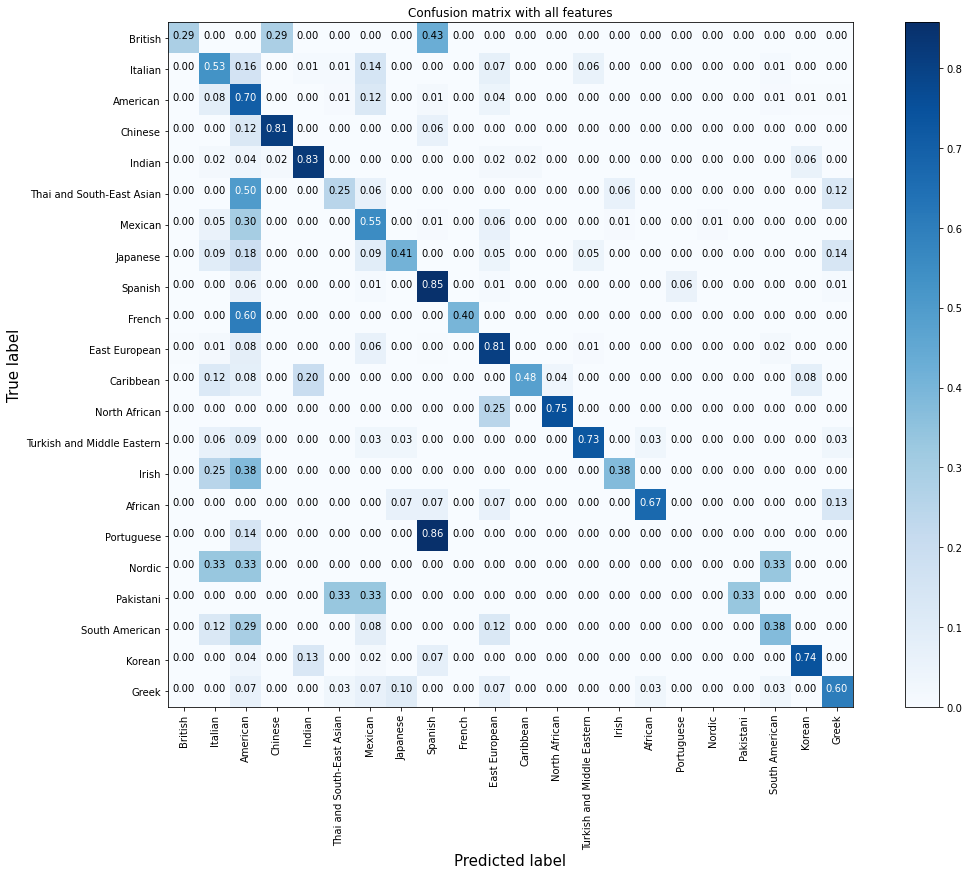

In [31]:
# print the confusion matrix
cnf_matrix = confusion_matrix(y_test, y_predicted_inversed)
plt.figure(figsize=(16, 12))
plot_confusion_matrix(cnf_matrix, classes=cuisine_list, normalize=True,
                      title='Confusion matrix with all features')

In [32]:
# Calculate classification report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_predicted_inversed,
                            target_names=cuisine_list))

                            precision    recall  f1-score   support

                   British       0.50      0.29      0.36         7
                   Italian       0.45      0.53      0.49        83
                  American       0.70      0.70      0.70       365
                   Chinese       0.81      0.81      0.81        16
                    Indian       0.77      0.83      0.80        52
 Thai and South-East Asian       0.40      0.25      0.31        16
                   Mexican       0.43      0.55      0.49       110
                  Japanese       0.64      0.41      0.50        22
                   Spanish       0.77      0.85      0.81        88
                    French       1.00      0.40      0.57         5
             East European       0.81      0.81      0.81       211
                 Caribbean       0.92      0.48      0.63        25
             North African       0.75      0.75      0.75         4
Turkish and Middle Eastern       0.75      0.73

In [33]:
# # Create the GridSearch estimator along with a parameter object containing the values to adjust
# from sklearn.model_selection import GridSearchCV
# param_grid = {'kernel': ["linear", "poly", "rbf", "sigmoid"]}
# grid = GridSearchCV(model, param_grid, verbose=3)